In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from iminuit import Minuit
from iminuit.cost import LeastSquares
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

In [2]:
with open('../../genIII_data/JLab/Beam/Beam1_0-Cal.pkl', 'rb') as file:
    # Load the data from the pickle file
    din = pickle.load(file)
with open("geometry.pkl", 'rb') as file:
    geometry = pickle.load(file)
    
e_cut = 0.3

In [21]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2. * sigma ** 2))


def get_energies_at(din, x_position, y_position, z_position):
    energies = []
    
    for event in din:
        arr = np.array(event)
        energy = arr[:, 0]
        x = arr[:, 1]
        y = arr[:, 2]
        z = arr[:, 3]

        # Find matching entries for the specific x, y, z positions
        mask = (x == x_position) & (y == y_position) & (z == z_position)
        energies.extend(energy[mask])
    
    return np.array(energies)

def get_all_positions(din):
    # Get the first event in din
    first_event = din[0]
    
    # Convert the first event to a numpy array
    arr = np.array(first_event)
    
    # Extract the x, y, z columns
    x_positions = arr[:, 1]
    y_positions = arr[:, 2]
    z_positions = arr[:, 3]
    
    # Create a list of all (x, y, z) positions as tuples
    positions = list(zip(x_positions, y_positions, z_positions))
    
    return positions


def get_position_from_layer_and_channel(positions, layer_number, channel_number):

    # Extract the unique z values (layers)
    z_values = np.unique([pos[2] for pos in positions])
    
    # Sort z values and map layer number to corresponding z position
    sorted_z_values = np.sort(z_values)
    layer_z = sorted_z_values[layer_number]

    # Filter positions for the given layer (z position)
    layer_positions = [pos for pos in positions if pos[2] == layer_z]

    # Calculate the corresponding (x, y) position based on the channel number
    # Channels are numbered bottom right to top left, so we reverse the grid order
    row = channel_number // 5
    col = channel_number % 5

    # Find the corresponding (x, y) position in the 5x5 grid
    channel_pos = layer_positions[row * 5 + col]
    x_pos, y_pos, _ = channel_pos  # We don't need the z here, we already have it

    return x_pos, y_pos, layer_z


def plot_energy_histograms(din, layer_number, positions, bins=100):
    # Set up the figure with a 5x5 grid of subplots
    cols = 5
    rows = 5  # Since it's a 5x5 grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharey=True, sharex=True)
    axes = axes.flatten()

    # Define the energy histogram range
    all_energies = []
    for ch in range(25):
        print(ch)
        x_pos, y_pos, z_pos = get_position_from_layer_and_channel(positions, layer_number, ch)
        energies = get_energies_at(din, x_pos, y_pos, z_pos)
        energies = energies[energies>0.3]
        all_energies.append(energies)

    # Plot histograms for each channel (starting with ch 0 in the lower right, ch 24 in the upper left)
    for ch in range(25):
        x_pos, y_pos, z_pos = get_position_from_layer_and_channel(positions, layer_number, ch)
        energies = all_energies[ch]
        ax = axes[24 - ch]  # Channel 0 is bottom right, Channel 24 is top left

        # Plot the histogram
        counts, bin_edges = np.histogram(energies, bins=bins, range=[0, 40])
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        errors = np.sqrt(counts)

        ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2, label=f'Ch {ch}')
        ax.set_ylim(1,8000)
        ax.set_yscale('log')
        ax.set_title(f'Ch {ch}')
        ax.legend()

    # Label only bottom row and left column
    for ax in axes[-cols:]:
        ax.set_xlabel("Energy [MIP]", fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel("Counts", fontsize=10)

    plt.suptitle(f"Layer {layer_number}", fontsize=18, y=1.0)
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


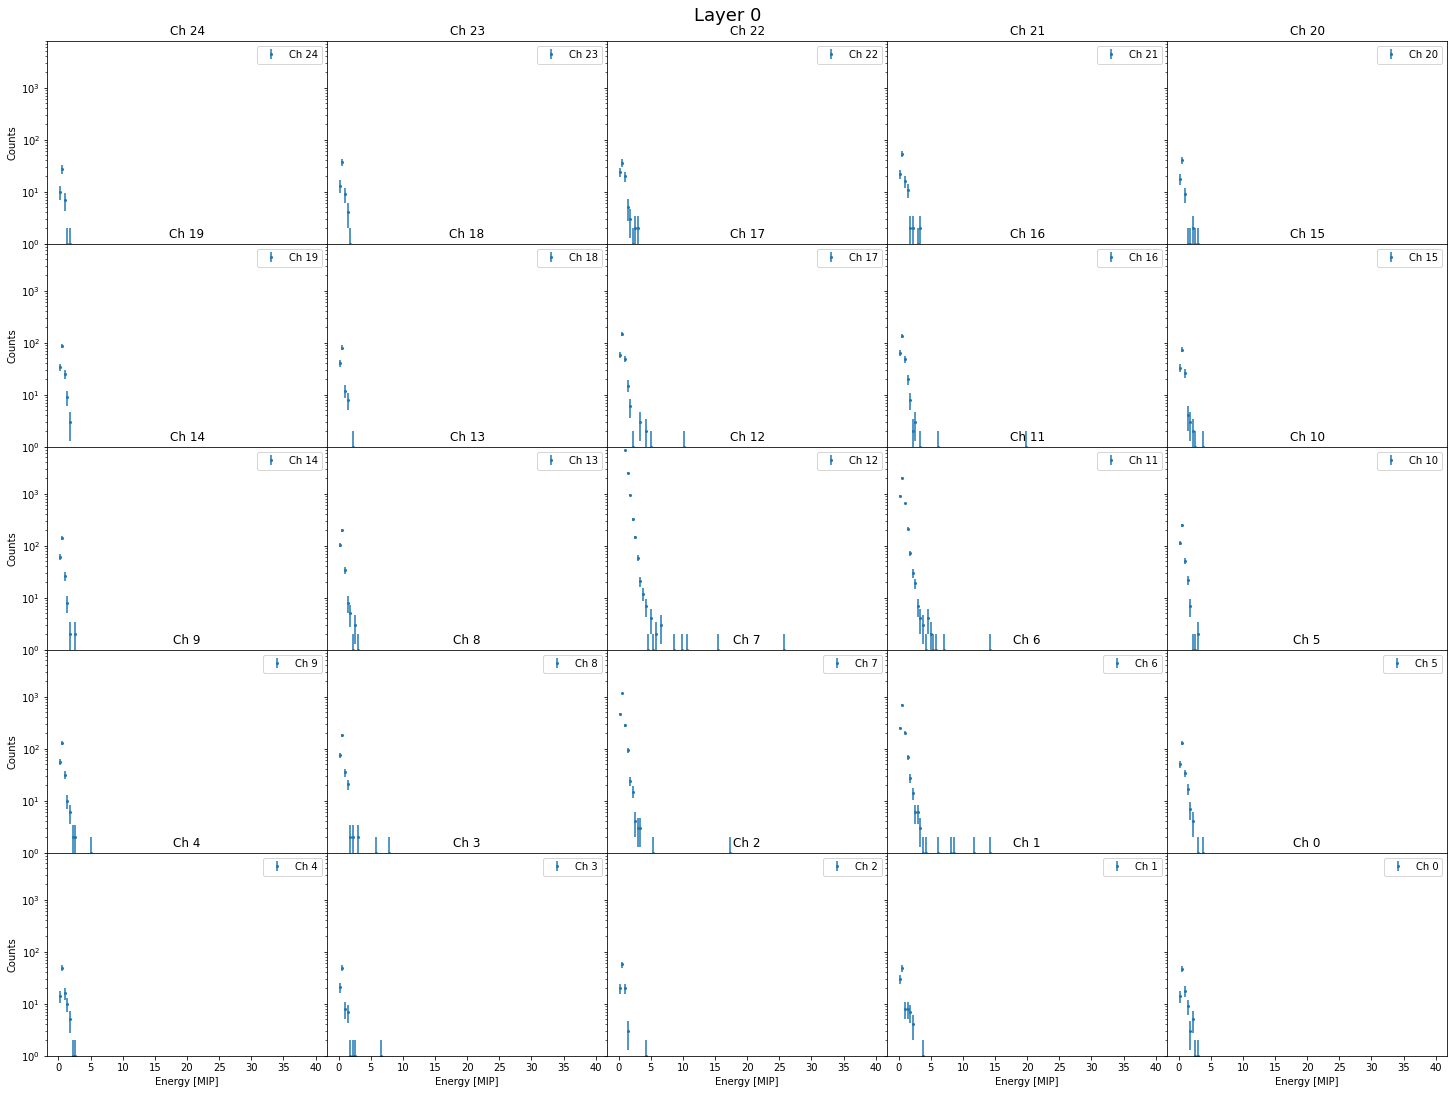

In [34]:
positions = get_all_positions(din)
for i in range(15):
    plot_energy_histograms(din, layer_number=i, positions=positions)

In [142]:
num_events = din.shape[0]
z_values_sorted = sorted(geometry["z"].unique())
num_layers = len(z_values_sorted)

# Map z -> layer index
z_to_layer_idx = {z: i for i, z in enumerate(z_values_sorted)}

# Initialize array: (num_events, num_layers)
layer_sums = np.zeros((num_events, num_layers))

for evt_idx, event in enumerate(din):
    for energy, x, y, z in event:
        if energy > e_cut:
            layer_idx = z_to_layer_idx[z]
            layer_sums[evt_idx, layer_idx] += energy


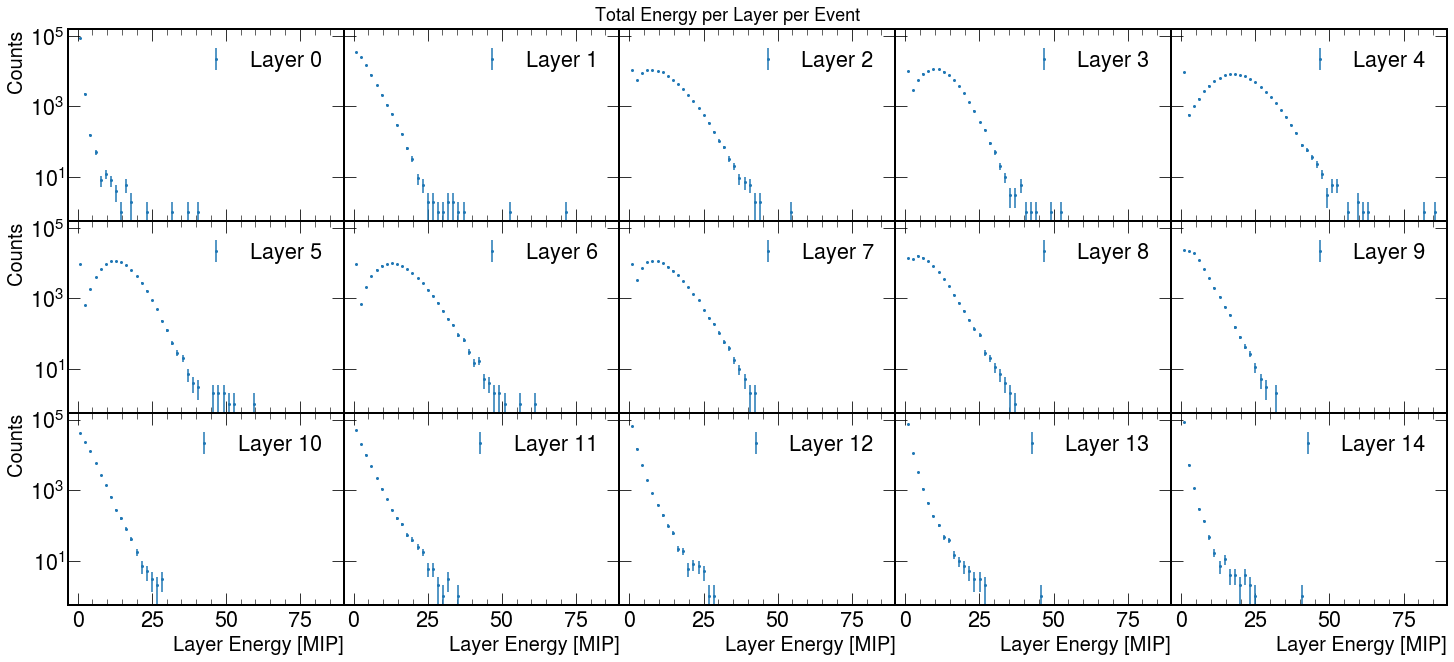

In [143]:
configure_plotting()
cols = 5
rows = (num_layers + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharey = True)
axes = axes.flatten()

bins = 50
range_ = (0, layer_sums.max())

for i in range(num_layers):
    data = layer_sums[:, i]
    counts, bin_edges = np.histogram(data, bins=bins, range=range_)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)

    ax = axes[i]
    ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2, label=f'Layer {i}')
    ax.set_yscale('log')
    ax.legend()

# Label only bottom row and left column
for ax in axes[-cols:]:
    ax.set_xlabel("Layer Energy [MIP]", fontsize=20)
for ax in axes[::cols]:
    ax.set_ylabel("Counts", fontsize=20)

# Hide unused axes
for ax in axes[num_layers:]:
    ax.axis("off")

plt.suptitle("Total Energy per Layer per Event", fontsize=18, y=1.0)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [36]:
evt_energy = []

for evt_idx, event in enumerate(din):
    energy = 0
    for e, x, y, z in event:
        if e > 0.3:
            energy += e
    evt_energy.append(energy)

Text(0.5, 1.0, 'Event Energy')

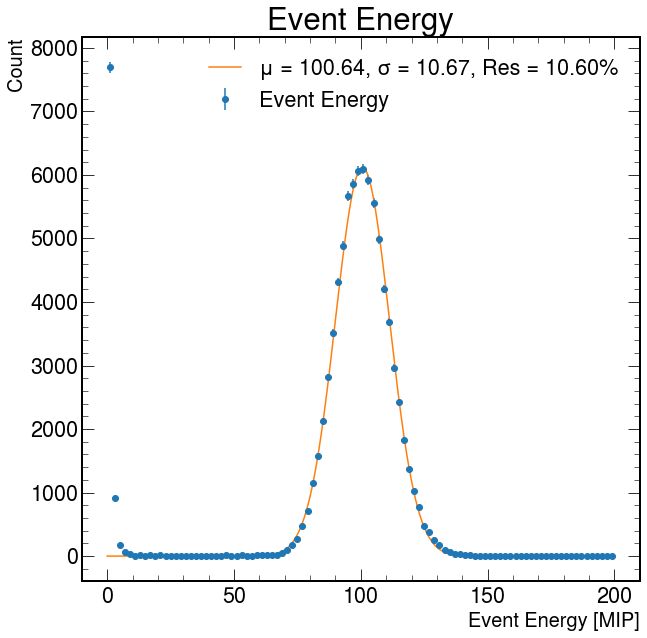

In [39]:
configure_plotting()
data = np.array(evt_energy)
counts, bin_edges = np.histogram(data, bins=100, range=[0, 200])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)

plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label="Event Energy")

# Only use bins with data for fitting
mask = counts > 0
x_data = bin_centers[mask]
y_data = counts[mask]
fit_errors = errors[mask]

# Fit with Minuit
initial_params = [max(y_data), np.mean(data[data>50]), np.std(data[data>50])]
least_squares = LeastSquares(x_data, y_data, fit_errors, gauss)
m = Minuit(least_squares, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()

# Extract results
fit_vals = m.values
fit_errs = m.errors
A_fit = fit_vals['A']
mu_fit = fit_vals['mu']
sigma_fit = fit_vals['sigma']
fit_x = np.linspace(0, 200, 1500)
fit_y = gauss(fit_x, A_fit, mu_fit, sigma_fit)
resolution = (sigma_fit / mu_fit) * 100
plt.plot(fit_x, fit_y, color='tab:orange',
         label=f"μ = {mu_fit:.2f}, σ = {sigma_fit:.2f}, Res = {resolution:.2f}%")
plt.legend()
#plt.yscale("log")
plt.xlabel("Event Energy [MIP]", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Event Energy")


In [127]:
for i in range(len(evt_energy)):
    if evt_energy[i] > 250:
        print(i)

13710
16271
20615
22370
27385
31094
34189
41792
47143
53694
68009
72683
75738


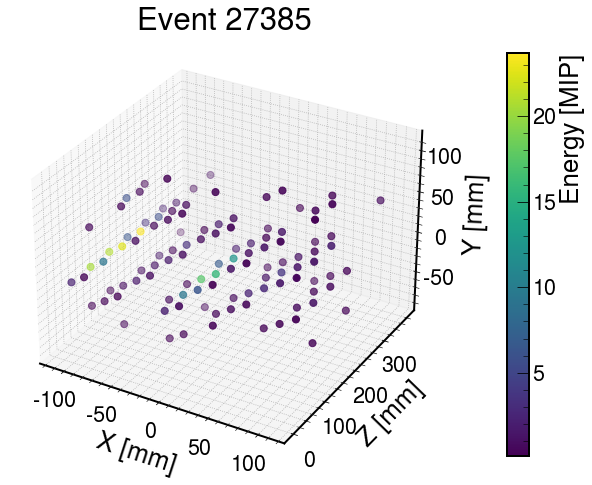

In [136]:
evtnum = 27385
event = din[evtnum]

# Filter for hits with energy > 0
energies = np.array([hit[0] for hit in event if hit[0] > 0])
xs = np.array([hit[1] for hit in event if hit[0] > 0])
ys = np.array([hit[2] for hit in event if hit[0] > 0])
zs = np.array([hit[3] for hit in event if hit[0] > 0])

# 3D scatterplot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xs, zs, ys, c=energies, cmap='viridis', s=50)

cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_label("Energy [MIP]")

ax.set_xlabel("X [mm]", labelpad=15)
ax.set_ylabel("Z [mm]", labelpad=15)
ax.set_zlabel("Y [mm]", labelpad=15)
ax.set_title(f"Event {evtnum}")
plt.subplots_adjust(right=0.85)


plt.show()

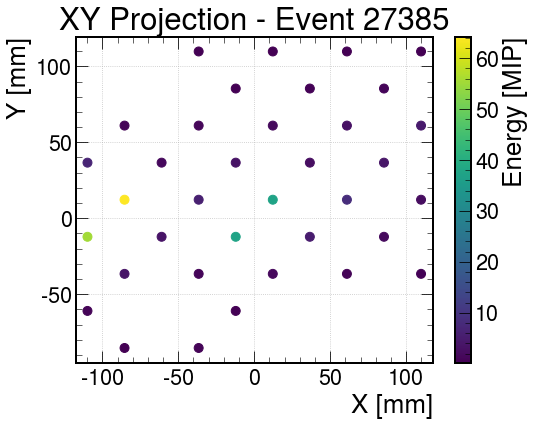

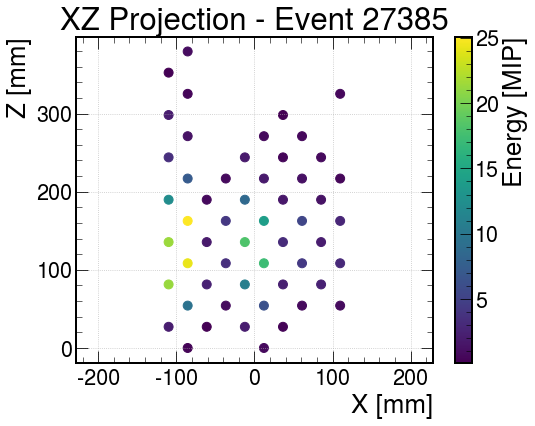

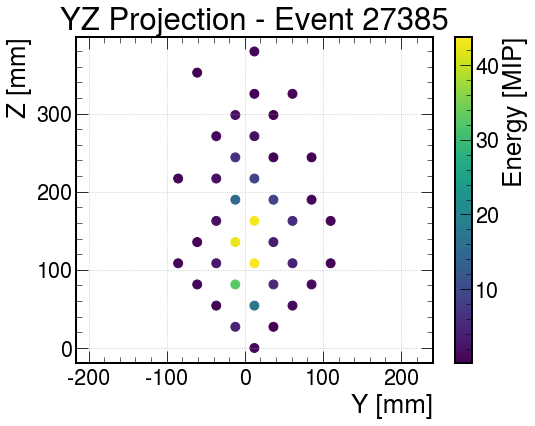

In [137]:
event = din[evtnum]

# Filter for hits with energy > 0
hits = np.array([hit for hit in event if hit[0] > 0])
energies, xs, ys, zs = hits[:, 0], hits[:, 1], hits[:, 2], hits[:, 3]

def plot_energy_projection(x, y, energy, xlabel, ylabel, title):
    # Create DataFrame for grouping
    df = pd.DataFrame({
        'x': x,
        'y': y,
        'energy': energy
    })

    # Group by position and sum energies
    grouped = df.groupby(['x', 'y']).sum().reset_index()

    # Make scatter plot
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(grouped['x'], grouped['y'], c=grouped['energy'], cmap='viridis', s=80)
    plt.colorbar(sc, label='Energy [MIP]')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')
    plt.show()
plot_energy_projection(xs, ys, energies, 'X [mm]', 'Y [mm]', f'XY Projection - Event {evtnum}')
plot_energy_projection(xs, zs, energies, 'X [mm]', 'Z [mm]', f'XZ Projection - Event {evtnum}')
plot_energy_projection(ys, zs, energies, 'Y [mm]', 'Z [mm]', f'YZ Projection - Event {evtnum}')